In [201]:
# try:
#     import dolfinx
# except ImportError:
#     !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a312183/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
#     import dolfinx

In [202]:
# try:
#      import viskex
# except ImportError:
#      !pip3 install "viskex@git+https://github.com/viskex/viskex.git@64c23fe"
#      import viskex

In [203]:
try:
    import gmsh
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a312183/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

In [204]:
import basix.ufl
import dolfinx.fem
import dolfinx.fem.petsc
import dolfinx.io
import gmsh
import mpi4py.MPI
import numpy as np
import numpy.typing
import petsc4py.PETSc # PETSc (the Portable, Extensible Toolkit for Scientific Computation)
import ufl
from mpi4py import MPI

**1. Geometry & Mesh**

In [205]:
def create_mesh_gmsh(
    L: int = 1,
    H: int = 1,
    res: float = 0.1,
    wall_marker: int = 2
):
    """
    Create a channel of length L, height H, rotated theta degrees
    around origin, with facet markers for inlet, outlet and walls.


    Parameters
    ----------
    L
        The length of the channel
    H
        Width of the channel
    res
        Mesh resolution (uniform)
    theta
        Rotation angle
    wall_marker
        Integer used to mark the walls of the channel
    outlet_marker
        Integer used to mark the outlet of the channel
    inlet_marker
        Integer used to mark the inlet of the channel
    """
    gmsh.initialize()
    if MPI.COMM_WORLD.rank == 0:
        gmsh.model.add("Square duct")

        # Create rectangular channel
        channel = gmsh.model.occ.addRectangle(0, 0, 0, L, H)
        gmsh.model.occ.synchronize()

        # Find entity markers before rotation
        surfaces = gmsh.model.occ.getEntities(dim=1)
        walls = []
        inlets = []
        outlets = []
        for surface in surfaces:
            com = gmsh.model.occ.getCenterOfMass(surface[0], surface[1])
            if np.allclose(com, [0, H / 2, 0]):
                inlets.append(surface[1])
            elif np.allclose(com, [L, H / 2, 0]):
                outlets.append(surface[1])
            elif np.isclose(com[1], 0) or np.isclose(com[1], H):
                walls.append(surface[1])
        gmsh.model.occ.synchronize()

        # Add physical markers
        gmsh.model.addPhysicalGroup(2, [channel], 1)
        gmsh.model.setPhysicalName(2, 1, "Fluid volume")
        gmsh.model.addPhysicalGroup(1, [walls], wall_marker)
        gmsh.model.setPhysicalName(1, wall_marker, "Walls")

        # Set number of threads used for mesh
        gmsh.option.setNumber("Mesh.MaxNumThreads1D", MPI.COMM_WORLD.size)
        gmsh.option.setNumber("Mesh.MaxNumThreads2D", MPI.COMM_WORLD.size)
        gmsh.option.setNumber("Mesh.MaxNumThreads3D", MPI.COMM_WORLD.size)

        # Set uniform mesh size
        gmsh.option.setNumber("Mesh.CharacteristicLengthMin", res)
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", res)

        # Generate mesh
        gmsh.model.mesh.generate(2)
    # Convert gmsh model to DOLFINx Mesh and meshtags
    mesh, _, ft = dolfinx.io.gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=2)
    gmsh.finalize()
    return mesh, ft



In [206]:
unstructured_mesh = False
if unstructured_mesh:
    # Create unstructured mesh
    mesh, mt = create_mesh_gmsh(res=0.1)
else:
    # Unit square domain [0, 1] x [0, 1] with (20,20) mesh elements
    n_elements = 20

    mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, n_elements, n_elements, cell_type= dolfinx.mesh.CellType.quadrilateral)


# Create connectivities required by the rest of the code
mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
tdim = mesh.topology.dim
num_cells = mesh.topology.index_map(tdim).size_local
cells = np.arange(num_cells, dtype=np.int32)
meshcpp = dolfinx.cpp.mesh.Mesh_float64(mesh.comm, mesh.topology, mesh.geometry)
h = dolfinx.cpp.mesh.h(meshcpp, tdim, cells)

print(f"mesh size = {h.max()}")
dt = h.max()**2
print(f"dt = {dt}")

mesh size = 0.07071067811865482
dt = 0.00500000000000001


In [207]:
print("mesh.geometry.dim = ", mesh.geometry.dim)
print("mesh.basix_cell() = ", mesh.basix_cell())

# velocity space element
V_element = basix.ufl.element("Lagrange", mesh.basix_cell(), 2, shape=(mesh.geometry.dim, ))
# Lagrange elements are commonly used for continuous function spaces
# polynomial degree of the Lagrange element is 1

# tensor space element
Q_element = basix.ufl.element("Lagrange", mesh.basix_cell(), 1, shape=(mesh.geometry.dim, mesh.geometry.dim), symmetry=True)


# symmetry=True => symmetric tensor field in case of stress tensor in viscoelastic fluid models

mesh.geometry.dim =  2
mesh.basix_cell() =  CellType.quadrilateral


**2. Function Spaces**

In [208]:
# define the function space
V = dolfinx.fem.functionspace(mesh, V_element)
Q = dolfinx.fem.functionspace(mesh, Q_element)

In [209]:
#!zip -r /content/file.zip /content/test_u.bp
#from google.colab import files
#files.download("/content/file.zip")


In [210]:
# interpolate velocity in the nodal value
class velocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((2, x.shape[1]), dtype=petsc4py.PETSc.ScalarType)
        values[0, :] = np.exp(-0.1*self.t)*np.sin(np.pi*x[0])
        values[1, :] = -np.pi*x[1]* np.cos(np.pi*x[0])*np.exp(-0.1*self.t)
        return values


u = dolfinx.fem.Function(V,name="velocity")
u_eval = velocity(0.0)
# u.interpolate(u_eval): Interpolates the u_eval function over the mesh, setting the values of u at the nodal points according to u_eval.
u.interpolate(u_eval)

with dolfinx.io.VTXWriter(mesh.comm,  f"test_u.bp", u) as vtx_u:
    vtx_u.write(0)
#https://fenicsproject.discourse.group/t/numerical-values-from-ufl-spatialcoordinate/11064/2

**3. Shear Stress Tensor**

In [211]:

x = ufl.SpatialCoordinate(mesh)

def stress(t):
    return ufl.as_tensor([
        [ufl.exp(-0.1 * t) * ufl.sin(ufl.pi * x[0]), -ufl.pi * x[1] * ufl.cos(ufl.pi * x[0]) * ufl.exp(-0.1 * t)],
        [-ufl.pi * x[1] * ufl.cos(ufl.pi * x[0]) * ufl.exp(-0.1 * t), ufl.sin(ufl.pi * x[0]) * ufl.cos(ufl.pi * x[1]) * ufl.exp(-0.1 * t)]
    ])
stress_expr_0 = dolfinx.fem.Expression(stress(0.0), Q.element.interpolation_points())

q_D = dolfinx.fem.Function(Q,name="stress")
q_D.interpolate(stress_expr_0)


**4. Boundary Conditions**

In [212]:

fdim = mesh.topology.dim - 1
if unstructured_mesh:
    boundary_facets=mt.find(1)
else:
    boundary_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))

print("boundary_facets = ", boundary_facets)


bc_D = dolfinx.fem.dirichletbc(q_D, dolfinx.fem.locate_dofs_topological(Q, fdim, boundary_facets))

boundary_facets =  [  0   1   3   5   9  13  17  23  27  35  39  49  53  65  69  83  87 103
 107 125 129 149 153 175 179 203 207 233 237 265 269 299 303 335 339 373
 377 413 417 455 458 459 496 497 498 533 534 567 568 599 600 629 630 657
 658 683 684 707 708 729 730 749 750 767 768 783 784 797 798 809 810 819
 820 827 828 833 834 837 838 839]


**5. Trial & Test Functions**

In [213]:
psi = ufl.TestFunction(Q)
tau = ufl.TrialFunction(Q)
dx=ufl.Measure("dx", domain=mesh, metadata={"quadrature_degree": 12})
Wi = 0.25


**6. Initial Condition**

In [214]:
# Create initial condition
q_n = dolfinx.fem.Function(Q)
q_n.name = "q_n"
q_n.interpolate(stress_expr_0)

with dolfinx.io.XDMFFile(mesh.comm, "initialStress.xdmf", "w", encoding=dolfinx.io.XDMFFile.Encoding.ASCII) as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(q_n)

supg_stabilization = True

In [215]:
def ConvectStress(u, tau):
   return ufl.dot(u,ufl.grad(tau))- ufl.dot( tau,ufl.grad(u)) - ufl.dot(ufl.grad(u).T,tau)

tau_mid = tau

lhs = Wi/dt*tau + tau_mid+ Wi* ConvectStress(u,tau_mid)

rhs = Wi/dt* q_n +  ufl.Identity(len(u))
#rhs = Wi/dt* q_n +  ufl.Identity(len(u))  - q_n - Wi* ConvectStress(u,q_n)


F = ufl.inner(lhs, psi)*dx
L = ufl.inner(rhs,psi)*dx


if supg_stabilization:
    # SUPG stabilization
    h = ufl.CellDiameter(mesh)
    magnitudeVel = ufl.sqrt(ufl.dot(u,u))


    alpha_supg = h /(magnitudeVel)

    #supg = ufl.inner( Wi*ConvectStress(u,tau), alpha_supg *ufl.dot(u, ufl.grad(psi)) )*dx
    #supg += ufl.inner(tau, alpha_supg *ufl.dot(u, ufl.grad(psi)) )*dx


    supgL = ufl.inner(rhs,alpha_supg *ufl.dot(u, ufl.grad(psi)))*dx
    supgF = ufl.inner(lhs,alpha_supg *ufl.dot(u, ufl.grad(psi)))*dx

    F += supgF
    L += supgL

In [216]:
!rm output/*
!mkdir -p output

In [217]:
# convergence error

def convergence(uh,uexact):

  error_local = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(uh - uexact, uh-uexact) * ufl.dx))
  den_local = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner( uexact, uexact) * ufl.dx))

  gradden_local = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner( ufl.grad( uexact), ufl.grad( uexact)) * ufl.dx))

  error_localH10 = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(ufl.grad(uh - uexact), ufl.grad(uh-uexact)) * ufl.dx) )/gradden_local


  error_L2 = numpy.sqrt(mesh.comm.allreduce(error_local, op=MPI.SUM))/numpy.sqrt(mesh.comm.allreduce(den_local, op=MPI.SUM))
  error_H01 =  numpy.sqrt(mesh.comm.allreduce(error_localH10, op=MPI.SUM))

  if mesh.comm.rank == 0:
      print(f"L2-error relative: {error_L2:.2e}")
      print(f"H01-error relative: {error_H01:.2e}")

  # Compute values at mesh vertices
  error_max = mesh.comm.allreduce(numpy.max(numpy.abs(uh.x.array - uexact.x.array)), op=MPI.MAX)
  if mesh.comm.rank == 0:
      print(f"Error_max: {error_max:.2e}")

  return error_max,error_L2,error_H01

In [218]:
from dolfinx.fem.petsc import LinearProblem

error = dolfinx.fem.Function(Q,name="error")
xdmf = dolfinx.io.XDMFFile(mesh.comm, "output/Stress.xdmf", "w", encoding=dolfinx.io.XDMFFile.Encoding.ASCII)

t = 0

xdmf.write_function(q_n,t)
num_dt = 20

problem = LinearProblem(F, L, bcs=[bc_D], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
# additional flags to have MUMPS as preconditioner
problem.solver.getPC().setFactorSolverType("mumps")
opts = petsc4py.PETSc.Options()
opts["mat_mumps_icntl_14"] = 80  # Increase MUMPS working memory
opts["ksp_error_if_not_converged"] = 1
opts["ksp_monitor"] = ""
problem.solver.setFromOptions()

for n in range(num_dt):
    print(n)
    t+=dt
    u_eval.t =  t
    u.interpolate(u_eval)
    stress_expr_t = dolfinx.fem.Expression(stress(t), Q.element.interpolation_points())
    q_D.interpolate(stress_expr_t)

    qh = problem.solve()
    qh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    q_n.x.array[:] = qh.x.array
    q_n.name="stress"
    xdmf.write_function(q_n,t)

    error.x.array[:] = q_n.x.array[:] - q_D.x.array[:]
    error.x.scatter_forward()
    xdmf.write_function(error,t)
    #u.name="velocity"
    #xdmf.write_function(u,t)
xdmf.close()

0


2024-06-14 18:58:59.360 (2430.956s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:58:59.477 (2431.074s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:58:59.492 (2431.089s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


1
2
3


2024-06-14 18:58:59.586 (2431.183s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:58:59.601 (2431.198s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:58:59.702 (2431.299s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:58:59.720 (2431.317s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:58:59.816 (2431.413s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


4


2024-06-14 18:58:59.838 (2431.434s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:58:59.938 (2431.535s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:58:59.957 (2431.554s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


5
6


2024-06-14 18:59:00.063 (2431.660s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.090 (2431.687s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.190 (2431.787s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.220 (2431.817s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


7
8


2024-06-14 18:59:00.330 (2431.927s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.352 (2431.948s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.459 (2432.056s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.464 (2432.061s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.560 (2432.157s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


9
10
11


2024-06-14 18:59:00.577 (2432.173s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.675 (2432.272s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.704 (2432.301s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


12


2024-06-14 18:59:00.812 (2432.409s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.845 (2432.442s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.949 (2432.546s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:00.984 (2432.581s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


13
14


2024-06-14 18:59:01.086 (2432.682s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:01.120 (2432.717s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:01.225 (2432.822s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:01.262 (2432.858s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


15
16


2024-06-14 18:59:01.364 (2432.961s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:01.403 (2433.000s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:01.508 (2433.105s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:01.555 (2433.152s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


17
18


2024-06-14 18:59:01.660 (2433.256s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:01.698 (2433.295s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:01.808 (2433.405s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


19


2024-06-14 18:59:02.031 (2433.628s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:02.157 (2433.754s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!
2024-06-14 18:59:02.182 (2433.778s) [main            ]           XDMFFile.cpp:256   WARN| No mesh found at '/Xdmf/Domain/Grid[@GridType='Uniform'][1]'. Write mesh before function!


In [219]:
stress_expr_t = dolfinx.fem.Expression(stress(t), Q.element.interpolation_points())
qexact = dolfinx.fem.Function(Q)
qexact.interpolate(stress_expr_t)
convergence(q_n,qexact)

L2-error relative: 3.30e-01
H01-error relative: 1.54e+00
Error_max: 2.15e+00


(2.1513403993173537, 0.3297929982864987, 1.5440762861358381)

In [220]:
# import viskex

In [221]:
# viskex.dolfinx.plot_vector_field(u,"velocity")

In [222]:

with dolfinx.io.XDMFFile(mesh.comm, "output/Stress_comparison.xdmf", "w", encoding=dolfinx.io.XDMFFile.Encoding.ASCII) as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(q_n)
    xdmf.write_function(qexact)


In [223]:

error.x.array[:] = q_n.x.array[:] - qexact.x.array[:]
error.x.scatter_forward()
with dolfinx.io.XDMFFile(mesh.comm, "output/Error.xdmf", "w", encoding=dolfinx.io.XDMFFile.Encoding.ASCII) as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(error)


In [224]:
#CFL
vnorm_form = ufl.dot(u,u)
vnorm_local= dolfinx.fem.assemble_scalar(dolfinx.fem.form(vnorm_form*ufl.dx))
vnorm = numpy.sqrt(mesh.comm.allreduce(vnorm_local, op=MPI.SUM))
tdim = mesh.topology.dim
num_cells = mesh.topology.index_map(tdim).size_local
cells = np.arange(num_cells, dtype=np.int32)
meshcpp = dolfinx.cpp.mesh.Mesh_float64(mesh.comm, mesh.topology, mesh.geometry)
h = dolfinx.cpp.mesh.h(meshcpp, tdim, cells)


In [225]:
print(Wi*np.max(h)/vnorm)


0.01219161549776273


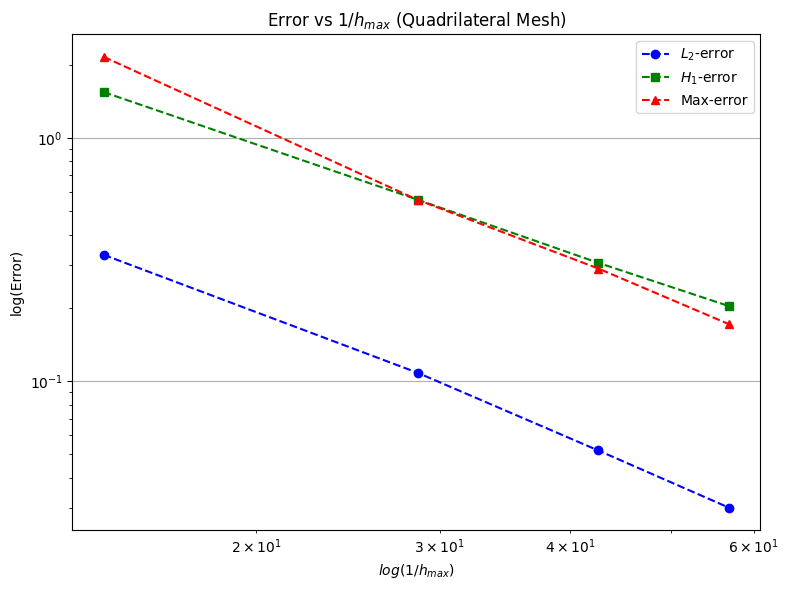

In [243]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
N = [20, 40, 60, 80]
h_max = [0.070, 0.035, 0.0235, 0.0176]
L2_error = [3.30e-01, 1.08e-01, 5.18e-02, 3.01e-02]
H1_error = [1.54e+00, 5.56e-01, 3.06e-01, 2.03e-01]
Max_error = [2.15e+00, 5.55e-01, 2.90e-01, 1.71e-01]

# Calculate 1/h_max
one_over_h_max = [1 / h for h in h_max]

# Plotting in log-log scale
plt.figure(figsize=(8, 6))

# Plot L2-error
plt.loglog(one_over_h_max, L2_error, marker='o', linestyle='--', color='b', label='$L_2$-error')

# Plot H1-error
plt.loglog(one_over_h_max, H1_error, marker='s', linestyle='--', color='g', label='$H_1$-error')

# Plot Max-error
plt.loglog(one_over_h_max, Max_error, marker='^', linestyle='--', color='r', label='Max-error')

plt.title('Error vs $1/h_{max}$ (Quadrilateral Mesh)')
plt.xlabel('$log(1/h_{max})$')
plt.ylabel('log(Error)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('ord_conv.png')
plt.show()


In [ ]:
!pip install tabulate
!pip install scikit-learn

In [237]:

import numpy as np
from tabulate import tabulate

# Data from the table
N = [20, 40, 60, 80]
h_max = np.array([0.070, 0.035, 0.0235, 0.0176])
L2_error = np.array([3.30e-01, 1.08e-01, 5.18e-02, 3.01e-02])
H1_error = np.array([1.54e+00, 5.56e-01, 3.06e-01, 2.03e-01])
Max_error = np.array([2.15e+00, 5.55e-01, 2.90e-01, 1.71e-01])

# Calculate the order of convergence for L2-error
order_L2 = np.zeros(len(N) - 1)
for i in range(len(N) - 1):
    order_L2[i] = np.log(L2_error[i] / L2_error[i + 1]) / np.log(h_max[i] / h_max[i + 1])

# Calculate the order of convergence for H1-error
order_H1 = np.zeros(len(N) - 1)
for i in range(len(N) - 1):
    order_H1[i] = np.log(H1_error[i] / H1_error[i + 1]) / np.log(h_max[i] / h_max[i + 1])

# Calculate the order of convergence for Max-error
order_Max = np.zeros(len(N) - 1)
for i in range(len(N) - 1):
    order_Max[i] = np.log(Max_error[i] / Max_error[i + 1]) / np.log(h_max[i] / h_max[i + 1])

# Create a table
table = [
    ["L_2-error", *order_L2],
    ["H_1-error", *order_H1],
    ["Max-error", *order_Max]
]

# Print the table using tabulate
print(tabulate(table, headers=["Error Type", "Order 1-2", "Order 2-3", "Order 3-4"], tablefmt="grid"))



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
+--------------+-------------+-------------+-------------+
| Error Type   |   Order 1-2 |   Order 2-3 |   Order 3-4 |
+==============+=============+=============+=============+
| L_2-error    |     1.61143 |     1.84447 |     1.87777 |
+--------------+-------------+-------------+-------------+
| H_1-error    |     1.46977 |     1.49915 |     1.4195  |
+--------------+-------------+-------------+-------------+
| Max-error    |     1.95378 |     1.62945 |     1.8271  |
+--------------+-------------+-------------+-------------+


  plt.tight_layout(pad=1.0)  # Increase padding if needed



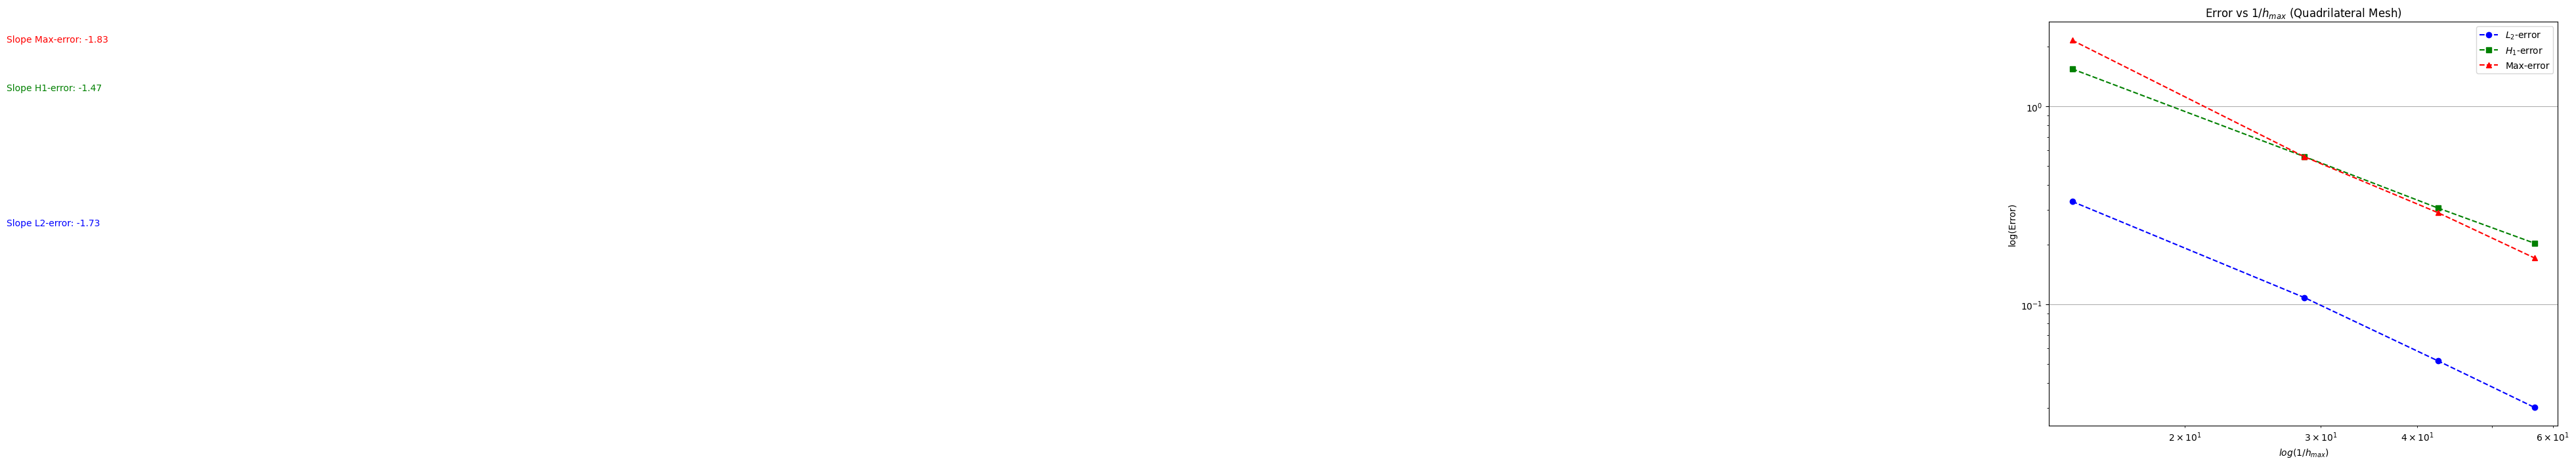